In [71]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb

In [72]:
# dataset used
# replace with Zach's df
df2 = pd.read_csv("0.1percent_2classes_processed.csv")
df8 = pd.read_csv("0.1percent_8classes_processed.csv")
df34 = pd.read_csv("0.1percent_34classes_processed.csv")

In [73]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "XGBoost", "Random Forest", "Random Forest - Bagging"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

# Processing and Splitting our dataset Function
80% Train 20% Test

In [74]:
# First, modify your split function to return the scaler
def split(df_name):
    if df_name == "df2":
        label = "benign"
        df = df2.sample(n=400000, random_state=42)
    else:
        label = "label"
        if df_name == "df8": df = df8.sample(n=400000, random_state=42)
        else: df = df34.sample(n=400000, random_state=42)
    
    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]
    
    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)  # Note: should use transform, not fit_transform here
    
    # encoding for XGBoost
    encoder = LabelEncoder()
    encoded_y_train = encoder.fit_transform(y_train)
    encoded_y_test = encoder.transform(y_test)  # Should use transform instead of fit_transform
    
    return scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler

# Evaluation Functions

In [75]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, y_test, target_names, classes, model_name):
    pred = model.predict(scaled_X_test)

    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])

    if model_name == "XGBoost":
        print(classification_report(y_test, pred, target_names = target_names, digits = 3))

        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);
    else:
        print(classification_report(y_test, pred, digits = 3))

        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);

In [76]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [77]:
# inspired from Zach
def get_weights(y_train):
    import math

    # Get counts in log10
    y_train_count = y_train.value_counts()
    y_log = y_train_count.apply(lambda x: math.log10(x))

    # Find the factor needed to bring minority classes to majority
    y_log_max = y_log.max()
    y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))

    weight_dict = y_log.to_dict()

    return weight_dict

# Save models


In [78]:
import os
import pickle

def save_model(model, model_name, class_type):
    """
    Save a trained model to disk based on classification type
    """
    # Create directory structure if it doesn't exist
    base_dir = os.path.join("saved_models", f"class_{class_type}")
    os.makedirs(base_dir, exist_ok=True)

    # Create file name with no spaces
    file_name = model_name.replace(" ", "_").lower() + ".pkl"
    file_path = os.path.join(base_dir, file_name)

    # Save the model using pickle
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)

    print(f"Model '{model_name}' saved for {class_type}-class classification at: {file_path}")

def save_scaler(scaler, class_type):
    """
    Save the fitted StandardScaler object
    """
    base_dir = os.path.join("saved_models", f"class_{class_type}")
    os.makedirs(base_dir, exist_ok=True)

    file_path = os.path.join(base_dir, "standard_scaler.pkl")

    with open(file_path, 'wb') as f:
        pickle.dump(scaler, f)

    print(f"Scaler saved for {class_type}-class classification at: {file_path}")

def load_model(model_name, class_type):
    """
    Load a saved model from disk
    """
    file_name = model_name.replace(" ", "_").lower() + ".pkl"
    file_path = os.path.join("saved_models", f"class_{class_type}", file_name)

    with open(file_path, 'rb') as f:
        model = pickle.load(f)

    return model

def load_scaler(class_type):
    """
    Load a saved scaler from disk
    """
    file_path = os.path.join("saved_models", f"class_{class_type}", "standard_scaler.pkl")

    with open(file_path, 'rb') as f:
        scaler = pickle.load(f)

    return scaler

# Example of how to save models after training
# For 2-class classification models
def save_models_for_class_2():
    # Save the scaler first
    # Make sure to get the scaler that was used to transform the training data
    save_scaler(scaler, 2)

    # Save all models
    save_model(logreg_model, "Logistic Regression", 2)
    save_model(clf, "Adaboost", 2)
    save_model(gbc, "Gradientboost", 2)
    save_model(knn, "KNN", 2)
    save_model(xgc, "XGBoost", 2)
    save_model(rfc, "Random Forest", 2)
    save_model(rfc, "Random Forest Bagging", 2)  # Make sure to rename variable

# Similar functions for 8-class and 34-class models
def save_models_for_class_8():
    save_scaler(scaler, 8)
    # Save all the 8-class models using the same pattern as above
    save_model(logreg_model, "Logistic Regression", 8)
    save_model(clf, "Adaboost", 8)
    save_model(gbc, "Gradientboost", 8)
    save_model(knn, "KNN", 8)
    save_model(xgc, "XGBoost", 8)
    save_model(rfc, "Random Forest", 8)
    save_model(rfcb, "Random Forest Bagging", 8)
    

def save_models_for_class_34():
    save_scaler(scaler, 34)
    # Save all the 34-class models using the same pattern as above
    save_model(logreg_model, "Logistic Regression", 34)
    save_model(clf, "Adaboost", 34)
    save_model(gbc, "Gradientboost", 34)
    save_model(knn, "KNN", 34)
    save_model(xgc, "XGBoost", 34)
    save_model(rfc, "Random Forest", 34)
    save_model(rfcb, "Random Forest Bagging", 34)

# Example of how to load and use a saved model for prediction
def load_and_predict(model_name, class_type, X_new):
    """
    Load a model and scaler, and make predictions on new data

    Parameters:
    -----------
    model_name : str
        Name of the model to load
    class_type : int
        Classification type (2, 8, or 34)
    X_new : array-like
        New data to predict on

    Returns:
    --------
    predictions : array
        Predicted classes
    """
    # Load model and scaler
    model = load_model(model_name, class_type)
    scaler = load_scaler(class_type)

    # Scale the new data
    X_new_scaled = scaler.transform(X_new)

    # Make predictions
    predictions = model.predict(X_new_scaled)

    return predictions

# **1-Supervised learning**

## 2 Classes

In [79]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler = split("df2")

In [80]:
weight_dict = get_weights(y_train)
weight_dict

{False: 1.0, True: 41.038885969521786}

In [81]:
# essential for XGBoost
target_names = ["Attack", "Benign"]

### Logistic Regression

              precision    recall  f1-score   support

       False      0.992     0.995     0.993     78097
        True      0.752     0.671     0.709      1903

    accuracy                          0.987     80000
   macro avg      0.872     0.833     0.851     80000
weighted avg      0.986     0.987     0.987     80000



<Figure size 1200x600 with 0 Axes>

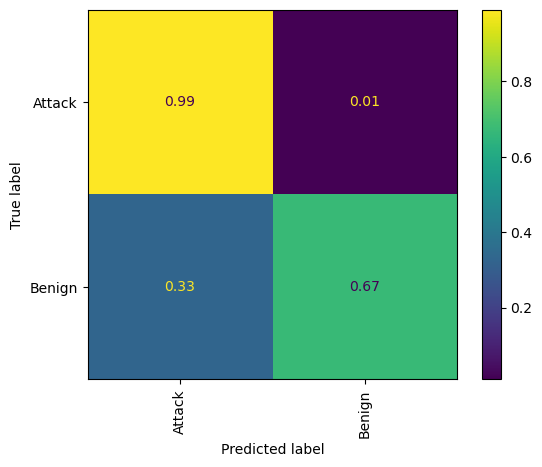

In [82]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 2, "Logistic Regression")



### Adaboost

              precision    recall  f1-score   support

       False      0.998     0.997     0.998     78097
        True      0.894     0.911     0.902      1903

    accuracy                          0.995     80000
   macro avg      0.946     0.954     0.950     80000
weighted avg      0.995     0.995     0.995     80000



<Figure size 1200x600 with 0 Axes>

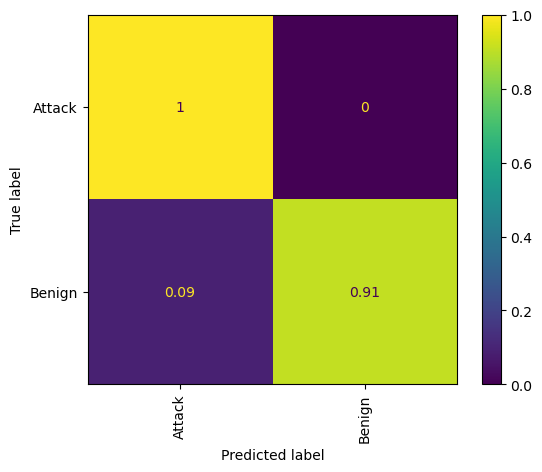

In [83]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 2, "Adaboost")


### Gradientboost

              precision    recall  f1-score   support

       False      0.998     0.998     0.998     78097
        True      0.911     0.912     0.912      1903

    accuracy                          0.996     80000
   macro avg      0.955     0.955     0.955     80000
weighted avg      0.996     0.996     0.996     80000



<Figure size 1200x600 with 0 Axes>

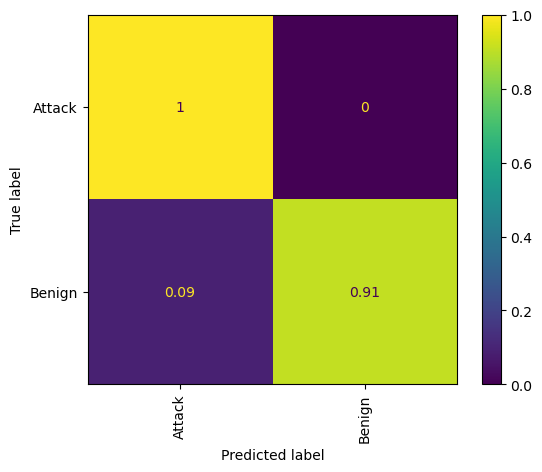

In [84]:
gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 2, "Gradientboost")


### KNN

              precision    recall  f1-score   support

       False      0.996     0.995     0.995     78097
        True      0.790     0.844     0.816      1903

    accuracy                          0.991     80000
   macro avg      0.893     0.919     0.906     80000
weighted avg      0.991     0.991     0.991     80000



<Figure size 1200x600 with 0 Axes>

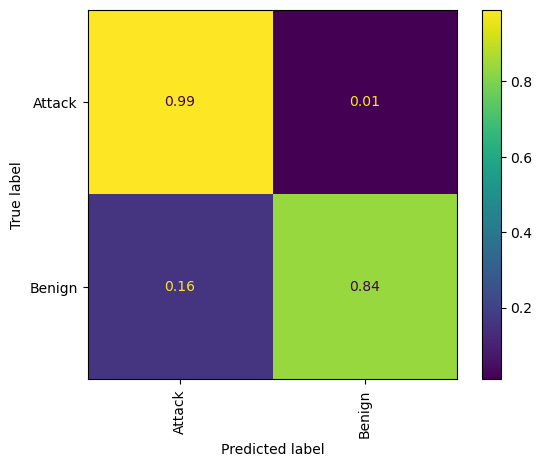

In [85]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 2, "KNN")



### XGBoost

              precision    recall  f1-score   support

      Attack      0.997     0.997     0.997     78097
      Benign      0.876     0.886     0.881      1903

    accuracy                          0.994     80000
   macro avg      0.937     0.942     0.939     80000
weighted avg      0.994     0.994     0.994     80000



<Figure size 1200x600 with 0 Axes>

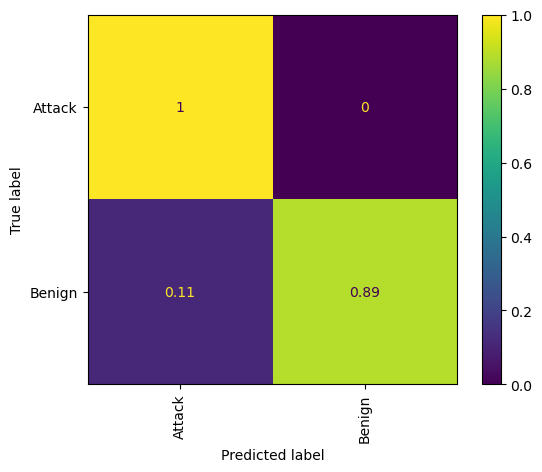

In [86]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13,n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 2, "XGBoost")



### Random Forest

              precision    recall  f1-score   support

       False      0.999     0.998     0.998     78097
        True      0.933     0.942     0.937      1903

    accuracy                          0.997     80000
   macro avg      0.966     0.970     0.968     80000
weighted avg      0.997     0.997     0.997     80000



<Figure size 1200x600 with 0 Axes>

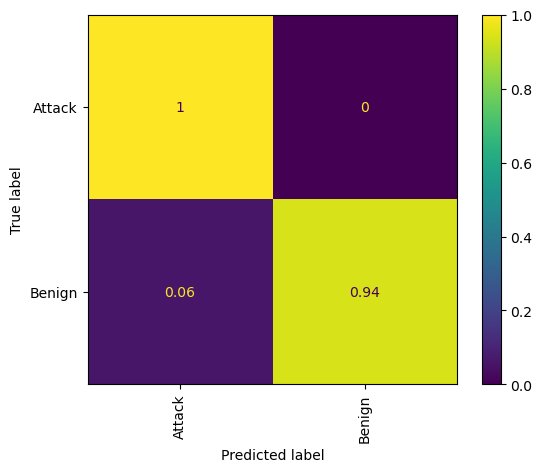

In [87]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100,n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest")


/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

              precision    recall  f1-score   support

       False      1.000     0.990     0.995     78097
        True      0.701     0.999     0.824      1903

    accuracy                          0.990     80000
   macro avg      0.850     0.995     0.909     80000
weighted avg      0.993     0.990     0.991     80000



<Figure size 1200x600 with 0 Axes>

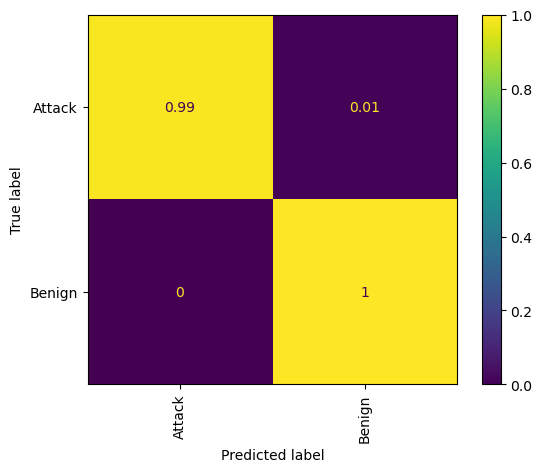

In [88]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest - Bagging")


In [89]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv('metrics_2.csv', index=True)
metrics_2
# Add:

,Logistic Regression,Adaboost,Gradientboost,KNN,XGBoost,Random Forest,Random Forest - Bagging
Accuracy,0.9869,0.995313,0.9958,0.990962,0.994325,0.997,0.989838
Recall,0.832821,0.954278,0.95504,0.919494,0.941724,0.97001,0.994539
Precision,0.871812,0.945825,0.954574,0.893136,0.936799,0.965713,0.850399
F1-Score,0.851175,0.950009,0.954807,0.905862,0.939247,0.967851,0.90934


In [90]:
save_models_for_class_2() 

Scaler saved for 2-class classification at: saved_models/class_2/standard_scaler.pkl
Model 'Logistic Regression' saved for 2-class classification at: saved_models/class_2/logistic_regression.pkl
Model 'Adaboost' saved for 2-class classification at: saved_models/class_2/adaboost.pkl
Model 'Gradientboost' saved for 2-class classification at: saved_models/class_2/gradientboost.pkl
Model 'KNN' saved for 2-class classification at: saved_models/class_2/knn.pkl
Model 'XGBoost' saved for 2-class classification at: saved_models/class_2/xgboost.pkl
Model 'Random Forest' saved for 2-class classification at: saved_models/class_2/random_forest.pkl
Model 'Random Forest Bagging' saved for 2-class classification at: saved_models/class_2/random_forest_bagging.pkl


## 8 Classes

In [125]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler  = split("df8")

In [126]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS': 1.0,
 'DoS': 4.22877773544513,
 'Mirai': 12.841496336290021,
 'Benign': 30.620861797162387,
 'Spoofing': 69.89085457271366,
 'Recon': 95.64464505539605,
 'Web': 1324.352272727273,
 'BruteForce': 2774.8333333333353}

In [127]:
y_test.value_counts()

label
DDoS          58272
DoS           13780
Mirai          4538
Benign         1903
Spoofing        833
Recon           609
Web              44
BruteForce       21
Name: count, dtype: int64

In [128]:
# essential for XGBoost
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

### Logistic Regression

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

              precision    recall  f1-score   support

      Benign      0.712     0.902     0.796      1903
  BruteForce      1.000     0.143     0.250        21
        DDoS      0.833     0.991     0.905     58272
         DoS      0.773     0.164     0.270     13780
       Mirai      0.991     0.991     0.991      4538
       Recon      0.575     0.360     0.442       609
    Spoofing      0.773     0.388     0.516       833
         Web      0.000     0.000     0.000        44

    accuracy                          0.834     80000
   macro avg      0.707     0.492     0.521     80000
weighted avg      0.826     0.834     0.790     80000



<Figure size 1200x600 with 0 Axes>

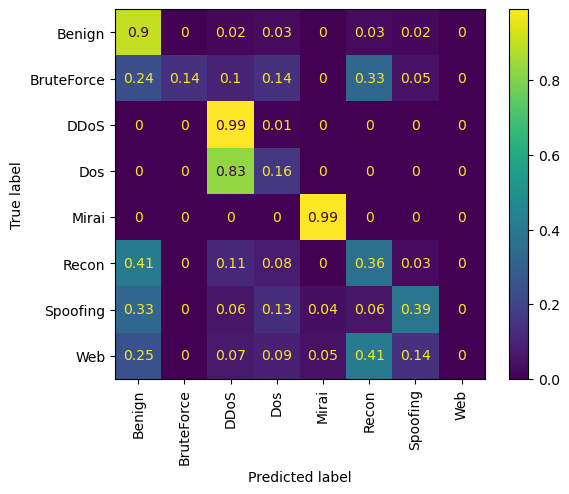

In [129]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42,n_jobs=-1)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 8, "Logistic Regression")


### Adaboost

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

              precision    recall  f1-score   support

      Benign      0.794     0.883     0.836      1903
  BruteForce      0.000     0.000     0.000        21
        DDoS      0.999     0.998     0.999     58272
         DoS      0.996     0.991     0.993     13780
       Mirai      0.995     0.989     0.992      4538
       Recon      0.594     0.617     0.605       609
    Spoofing      0.685     0.695     0.690       833
         Web      0.000     0.000     0.000        44

    accuracy                          0.987     80000
   macro avg      0.633     0.647     0.639     80000
weighted avg      0.986     0.987     0.986     80000



<Figure size 1200x600 with 0 Axes>

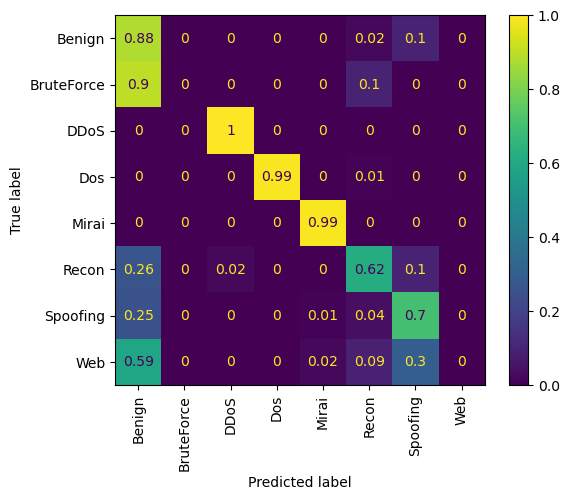

In [130]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 8, "Adaboost")


### Gradientboost

              precision    recall  f1-score   support

      Benign      0.938     0.842     0.887      1903
  BruteForce      0.381     0.381     0.381        21
        DDoS      0.996     1.000     0.998     58272
         DoS      0.999     0.999     0.999     13780
       Mirai      0.996     0.999     0.998      4538
       Recon      0.831     0.805     0.817       609
    Spoofing      0.841     0.830     0.835       833
         Web      0.568     0.568     0.568        44

    accuracy                          0.992     80000
   macro avg      0.819     0.803     0.811     80000
weighted avg      0.992     0.992     0.992     80000



<Figure size 1200x600 with 0 Axes>

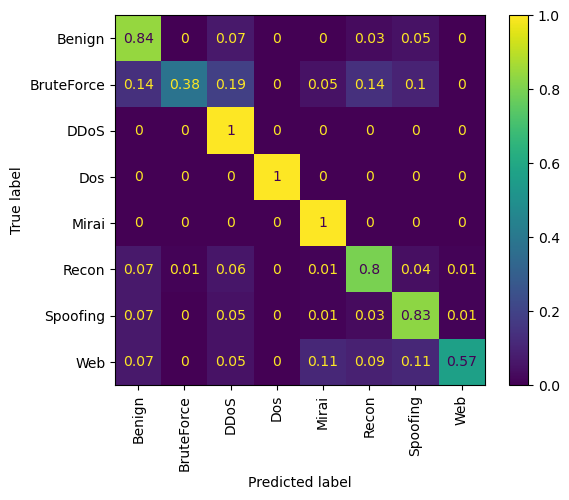

In [99]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)


evaluate(gbc, y_test, target_names, 8, "Gradientboost")



# KNN

              precision    recall  f1-score   support

      Benign      0.737     0.943     0.827      1903
  BruteForce      1.000     0.095     0.174        21
        DDoS      0.958     0.985     0.971     58272
         DoS      0.928     0.819     0.870     13780
       Mirai      0.997     0.993     0.995      4538
       Recon      0.760     0.567     0.649       609
    Spoofing      0.757     0.483     0.589       833
         Web      0.000     0.000     0.000        44

    accuracy                          0.946     80000
   macro avg      0.767     0.611     0.634     80000
weighted avg      0.946     0.946     0.944     80000



<Figure size 1200x600 with 0 Axes>

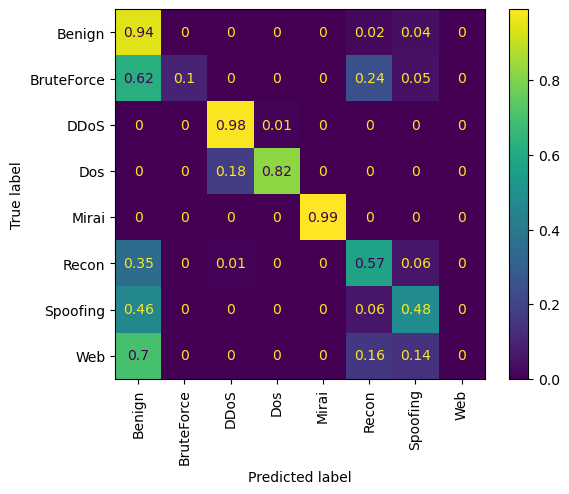

In [100]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 8, "KNN")



## XGBoost

/home/faissalm/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:52:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_samples" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

      Benign      0.898     0.940     0.918      1903
  BruteForce      0.200     0.048     0.077        21
        DDoS      1.000     1.000     1.000     58272
         Dos      0.999     0.999     0.999     13780
       Mirai      1.000     1.000     1.000      4538
       Recon      0.831     0.759     0.793       609
    Spoofing      0.800     0.809     0.805       833
         Web      0.562     0.205     0.300        44

    accuracy                          0.994     80000
   macro avg      0.786     0.720     0.737     80000
weighted avg      0.993     0.994     0.994     80000



<Figure size 1200x600 with 0 Axes>

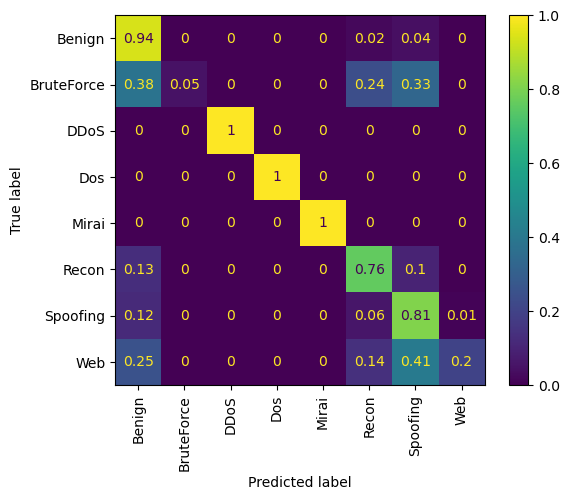

In [101]:
# Required to be trained on scaled_X_train, encoded_y_train
# evaluate parameter for y_test to be encoded y_test
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9 ,n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 8, "XGBoost")


## Random Forest

              precision    recall  f1-score   support

      Benign      0.901     0.971     0.934      1903
  BruteForce      1.000     0.048     0.091        21
        DDoS      1.000     1.000     1.000     58272
         DoS      1.000     0.999     0.999     13780
       Mirai      1.000     1.000     1.000      4538
       Recon      0.876     0.788     0.830       609
    Spoofing      0.864     0.831     0.847       833
         Web      1.000     0.182     0.308        44

    accuracy                          0.995     80000
   macro avg      0.955     0.727     0.751     80000
weighted avg      0.995     0.995     0.995     80000



<Figure size 1200x600 with 0 Axes>

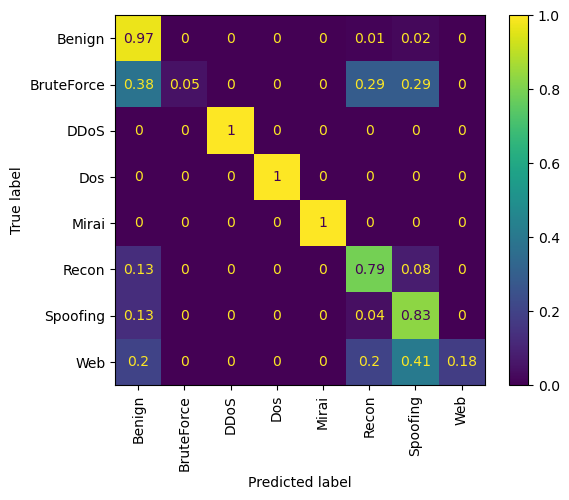

In [102]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100 ,n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest")


/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

              precision    recall  f1-score   support

      Benign      0.882     0.811     0.845      1903
  BruteForce      0.049     0.857     0.094        21
        DDoS      1.000     0.979     0.989     58272
         DoS      0.966     0.981     0.973     13780
       Mirai      0.999     0.988     0.994      4538
       Recon      0.377     0.644     0.475       609
    Spoofing      0.594     0.689     0.638       833
         Web      0.054     0.364     0.094        44

    accuracy                          0.970     80000
   macro avg      0.615     0.789     0.638     80000
weighted avg      0.981     0.970     0.975     80000



<Figure size 1200x600 with 0 Axes>

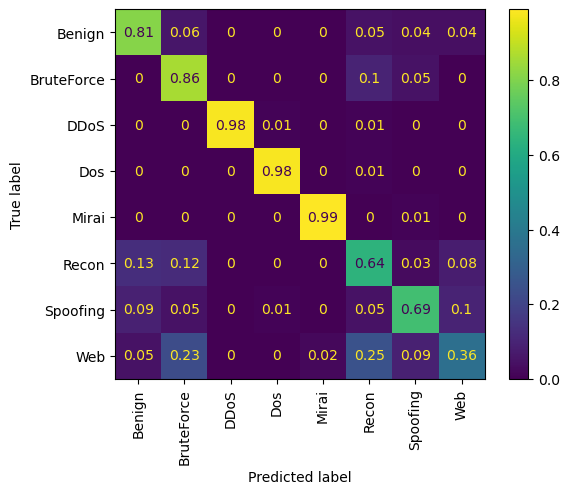

In [132]:
# Bagging-balanced
rfcb = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True ,n_jobs=-1)
rfcb.fit(scaled_X_train, y_train)

evaluate(rfcb, y_test, target_names, 8, "Random Forest - Bagging")


In [133]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv('metrics_8.csv', index=True)
metrics_8

,Logistic Regression,Adaboost,Gradientboost,KNN,XGBoost,Random Forest,Random Forest - Bagging
Accuracy,0.83435,0.986513,0.992287,0.946338,0.993738,0.994988,0.9703
Recall,0.492227,0.646662,0.802963,0.610501,0.71978,0.727255,0.789175
Precision,0.707116,0.632825,0.818761,0.767016,0.786364,0.954936,0.614989
F1-Score,0.521394,0.639412,0.810506,0.634444,0.736504,0.751087,0.637716


In [134]:
save_models_for_class_8()

Scaler saved for 8-class classification at: saved_models/class_8/standard_scaler.pkl
Model 'Logistic Regression' saved for 8-class classification at: saved_models/class_8/logistic_regression.pkl
Model 'Adaboost' saved for 8-class classification at: saved_models/class_8/adaboost.pkl
Model 'Gradientboost' saved for 8-class classification at: saved_models/class_8/gradientboost.pkl
Model 'KNN' saved for 8-class classification at: saved_models/class_8/knn.pkl
Model 'XGBoost' saved for 8-class classification at: saved_models/class_8/xgboost.pkl
Model 'Random Forest' saved for 8-class classification at: saved_models/class_8/random_forest.pkl
Model 'Random Forest Bagging' saved for 8-class classification at: saved_models/class_8/random_forest_bagging.pkl


# 34 Classes

In [135]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test, scaler  = split("df34")

In [136]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS-ICMP_Flood': 1.0,
 'DDoS-UDP_Flood': 1.3377724952051644,
 'DDoS-TCP_Flood': 1.6089866467396619,
 'DDoS-PSHACK_Flood': 1.771082182962593,
 'DDoS-SYN_Flood': 1.7730478679603316,
 'DDoS-RSTFINFlood': 1.7818515453531467,
 'DDoS-SynonymousIP_Flood': 2.003276566481937,
 'DoS-UDP_Flood': 2.215298590919256,
 'DoS-TCP_Flood': 2.703810875737061,
 'DoS-SYN_Flood': 3.5541122434333285,
 'BenignTraffic': 6.505911718339464,
 'Mirai-greeth_flood': 7.36511005353956,
 'Mirai-udpplain': 7.996609074761831,
 'Mirai-greip_flood': 9.45998089780325,
 'DDoS-ICMP_Fragmentation': 16.157585644371945,
 'MITM-ArpSpoofing': 23.098414179104488,
 'DDoS-UDP_Fragmentation': 24.873430436966355,
 'DDoS-ACK_Fragmentation': 25.448612538540594,
 'DNS_Spoofing': 41.61596638655464,
 'Recon-HostDiscovery': 53.30785791173304,
 'Recon-OSScan': 74.35885885885888,
 'Recon-PortScan': 88.7508960573477,
 'DoS-HTTP_Flood': 96.34824902723733,
 'VulnerabilityScan': 181.40293040293042,
 'DDoS-HTTP_Flood': 263.42021276595733,
 'DDoS

In [137]:
y_test.value_counts()

label
DDoS-ICMP_Flood            12381
DDoS-UDP_Flood              9254
DDoS-TCP_Flood              7695
DDoS-PSHACK_Flood           6990
DDoS-SYN_Flood              6983
DDoS-RSTFINFlood            6948
DDoS-SynonymousIP_Flood     6180
DoS-UDP_Flood               5589
DoS-TCP_Flood               4579
DoS-SYN_Flood               3483
BenignTraffic               1903
Mirai-greeth_flood          1681
Mirai-udpplain              1548
Mirai-greip_flood           1308
DDoS-ICMP_Fragmentation      766
MITM-ArpSpoofing             536
DDoS-UDP_Fragmentation       498
DDoS-ACK_Fragmentation       487
DNS_Spoofing                 298
Recon-HostDiscovery          232
Recon-OSScan                 166
Recon-PortScan               140
DoS-HTTP_Flood               129
VulnerabilityScan             68
DDoS-HTTP_Flood               47
DDoS-SlowLoris                42
DictionaryBruteForce          21
BrowserHijacking              11
SqlInjection                  10
CommandInjection               9
XSS 

In [138]:
# essential for XGBoost
target_names = list(y_test.unique())

## Logistic Regression

In [139]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42, n_jobs=-1)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 34, "Logistic Regression")


/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         5
          BenignTraffic      0.671     0.936     0.782      1903
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.730     0.133     0.226       487
        DDoS-HTTP_Flood      0.439     0.383     0.409        47
        DDoS-ICMP_Flood      0.974     0.996     0.985     12381
DDoS-ICMP_Fragmentation      0.615     0.970     0.753       766
      DDoS-PSHACK_Flood      0.999     0.983     0.991      6990
       DDoS-RSTFINFlood      0.999     1.000     0.999      6948
         DDoS-SYN_Flood      0.652     0.966     0.779      6983
         DDoS-SlowLoris      0.250     0.167     0.200        42
DDoS-SynonymousIP_Flood      0.759     0.686     0.721      6180
         DDoS-TCP_Flood      0.620     0.939     0.747      7695
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Adaboost

In [140]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42 )
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 34, "Adaboost")


/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         5
          BenignTraffic      0.600     0.955     0.737      1903
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.440     0.889     0.589       487
        DDoS-HTTP_Flood      0.000     0.000     0.000        47
        DDoS-ICMP_Flood      0.975     0.998     0.986     12381
DDoS-ICMP_Fragmentation      0.694     0.077     0.139       766
      DDoS-PSHACK_Flood      0.994     0.998     0.996      6990
       DDoS-RSTFINFlood      0.997     0.996     0.997      6948
         DDoS-SYN_Flood      0.000     0.000     0.000      6983
         DDoS-SlowLoris      0.000     0.000     0.000        42
DDoS-SynonymousIP_Flood      0.465     0.999     0.634      6180
         DDoS-TCP_Flood      0.936     0.998     0.966      7695
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Gradientboost

In [141]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 34, "Gradientboost")


                         precision    recall  f1-score   support

       Backdoor_Malware      0.200     0.200     0.200         5
          BenignTraffic      0.937     0.847     0.890      1903
       BrowserHijacking      0.533     0.727     0.615        11
       CommandInjection      0.429     0.333     0.375         9
 DDoS-ACK_Fragmentation      0.998     0.986     0.992       487
        DDoS-HTTP_Flood      0.884     0.809     0.844        47
        DDoS-ICMP_Flood      0.999     1.000     1.000     12381
DDoS-ICMP_Fragmentation      0.995     0.991     0.993       766
      DDoS-PSHACK_Flood      0.999     1.000     0.999      6990
       DDoS-RSTFINFlood      0.999     1.000     1.000      6948
         DDoS-SYN_Flood      0.994     1.000     0.997      6983
         DDoS-SlowLoris      0.976     0.976     0.976        42
DDoS-SynonymousIP_Flood      1.000     1.000     1.000      6180
         DDoS-TCP_Flood      0.970     1.000     0.985      7695
         DDoS-UDP_Flood 

## KNN

In [142]:
knn = KNeighborsClassifier(n_neighbors = 8, n_jobs=-1)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 34, "KNN")


/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         5
          BenignTraffic      0.711     0.953     0.814      1903
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.694     0.653     0.673       487
        DDoS-HTTP_Flood      0.551     0.574     0.562        47
        DDoS-ICMP_Flood      0.988     0.995     0.991     12381
DDoS-ICMP_Fragmentation      0.744     0.819     0.779       766
      DDoS-PSHACK_Flood      1.000     0.996     0.998      6990
       DDoS-RSTFINFlood      0.999     1.000     0.999      6948
         DDoS-SYN_Flood      0.904     0.964     0.933      6983
         DDoS-SlowLoris      0.718     0.667     0.691        42
DDoS-SynonymousIP_Flood      0.957     0.946     0.952      6180
         DDoS-TCP_Flood      0.923     0.972     0.947      7695
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost

In [144]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9 , n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 34, "XGBoost")


/home/faissalm/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:54:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_samples" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                         precision    recall  f1-score   support

         DDoS-SYN_Flood      0.000     0.000     0.000         5
        DDoS-ICMP_Flood      0.000     0.000     0.000      1903
       DDoS-RSTFINFlood      0.000     0.000     0.000        11
         DDoS-UDP_Flood      0.000     0.000     0.000         9
      DDoS-PSHACK_Flood      0.000     0.000     0.000       487
         DDoS-TCP_Flood      0.000     0.000     0.000        47
          DoS-TCP_Flood      0.000     0.000     0.000     12381
DDoS-ICMP_Fragmentation      0.000     0.000     0.000       766
          DoS-SYN_Flood      0.000     0.000     0.000      6990
DDoS-SynonymousIP_Flood      0.000     0.000     0.000      6948
         Mirai-udpplain      0.026     0.013     0.017      6983
          BenignTraffic      0.000     0.000     0.000        42
         Recon-PortScan      0.242     0.069     0.108      6180
      Mirai-greip_flood      0.103     0.992     0.186      7695
          DoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

## Random Forest

In [145]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100 , n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest")



/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         5
          BenignTraffic      0.862     0.983     0.918      1903
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.996     0.990     0.993       487
        DDoS-HTTP_Flood      0.958     0.979     0.968        47
        DDoS-ICMP_Flood      1.000     1.000     1.000     12381
DDoS-ICMP_Fragmentation      0.990     0.991     0.990       766
      DDoS-PSHACK_Flood      1.000     0.999     0.999      6990
       DDoS-RSTFINFlood      1.000     1.000     1.000      6948
         DDoS-SYN_Flood      0.999     0.999     0.999      6983
         DDoS-SlowLoris      0.930     0.952     0.941        42
DDoS-SynonymousIP_Flood      1.000     1.000     1.000      6180
         DDoS-TCP_Flood      1.000     1.000     1.000      7695
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [146]:
# Bagging-balanced
rfcb = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfcb.fit(scaled_X_train, y_train)
evaluate(rfcb, y_test, target_names, 34, "Random Forest - Bagging")

/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         5
          BenignTraffic      0.877     0.625     0.730      1903
       BrowserHijacking      0.032     0.455     0.060        11
       CommandInjection      0.023     0.111     0.038         9
 DDoS-ACK_Fragmentation      0.967     0.975     0.971       487
        DDoS-HTTP_Flood      0.175     0.872     0.292        47
        DDoS-ICMP_Flood      0.976     0.996     0.986     12381
DDoS-ICMP_Fragmentation      1.000     0.946     0.973       766
      DDoS-PSHACK_Flood      0.997     0.995     0.996      6990
       DDoS-RSTFINFlood      1.000     0.998     0.999      6948
         DDoS-SYN_Flood      0.972     0.920     0.945      6983
         DDoS-SlowLoris      0.246     0.762     0.372        42
DDoS-SynonymousIP_Flood      0.957     0.967     0.962      6180
         DDoS-TCP_Flood      0.994     0.971     0.982      7695
         DDoS-UDP_Flood 

In [147]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv('metrics_34.csv', index=True)
metrics_34

,Logistic Regression,Adaboost,Gradientboost,KNN,XGBoost,Random Forest,Random Forest - Bagging
Accuracy,0.784225,0.756175,0.989675,0.930475,0.102038,0.993062,0.954825
Recall,0.423299,0.329047,0.838182,0.58137,0.031654,0.717702,0.714105
Precision,0.50763,0.353029,0.806386,0.622386,0.01178,0.758307,0.590585
F1-Score,0.421282,0.296665,0.813165,0.59176,0.009223,0.727089,0.594726


In [148]:
save_models_for_class_34()

Scaler saved for 34-class classification at: saved_models/class_34/standard_scaler.pkl
Model 'Logistic Regression' saved for 34-class classification at: saved_models/class_34/logistic_regression.pkl
Model 'Adaboost' saved for 34-class classification at: saved_models/class_34/adaboost.pkl
Model 'Gradientboost' saved for 34-class classification at: saved_models/class_34/gradientboost.pkl
Model 'KNN' saved for 34-class classification at: saved_models/class_34/knn.pkl
Model 'XGBoost' saved for 34-class classification at: saved_models/class_34/xgboost.pkl
Model 'Random Forest' saved for 34-class classification at: saved_models/class_34/random_forest.pkl
Model 'Random Forest Bagging' saved for 34-class classification at: saved_models/class_34/random_forest_bagging.pkl


# Metric Plot

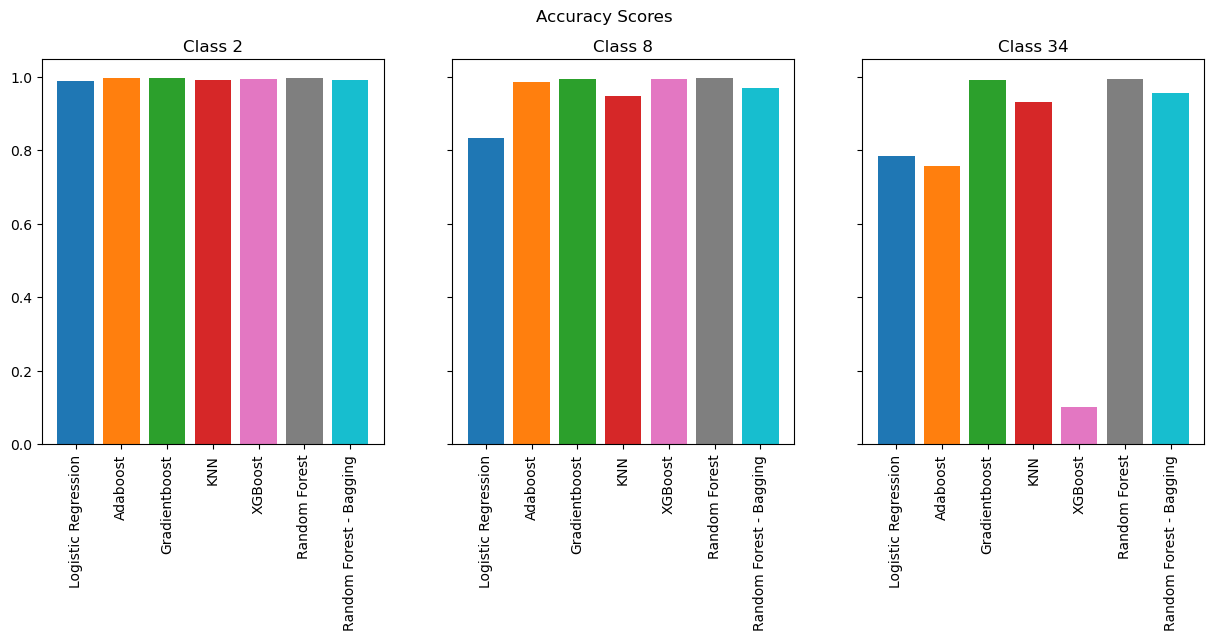

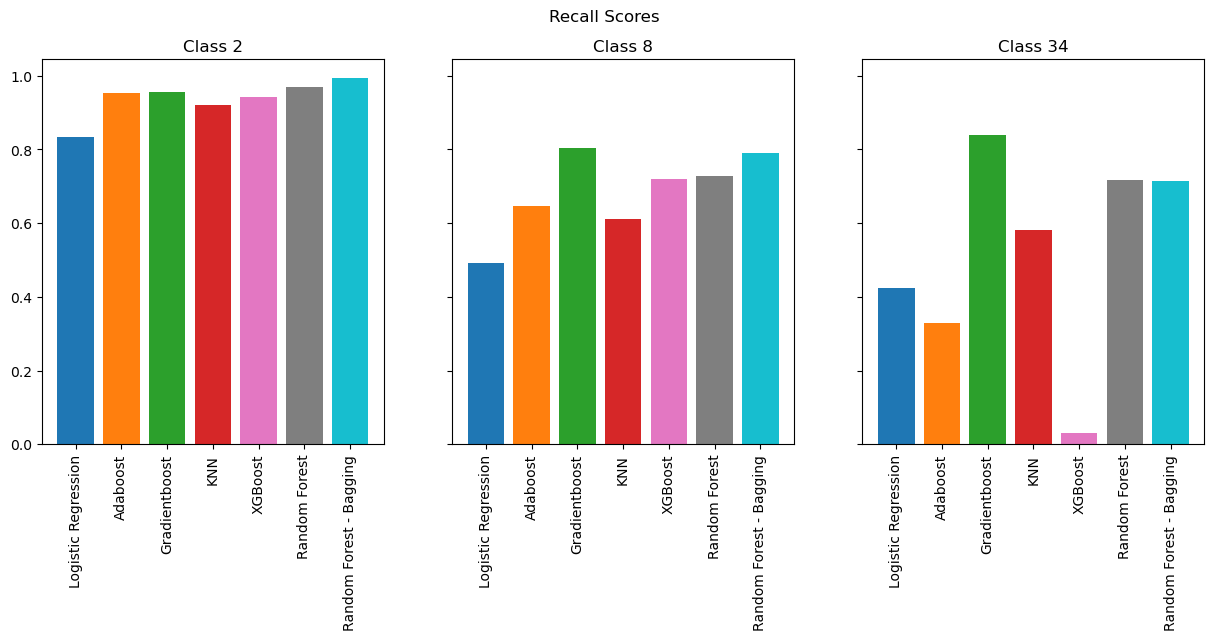

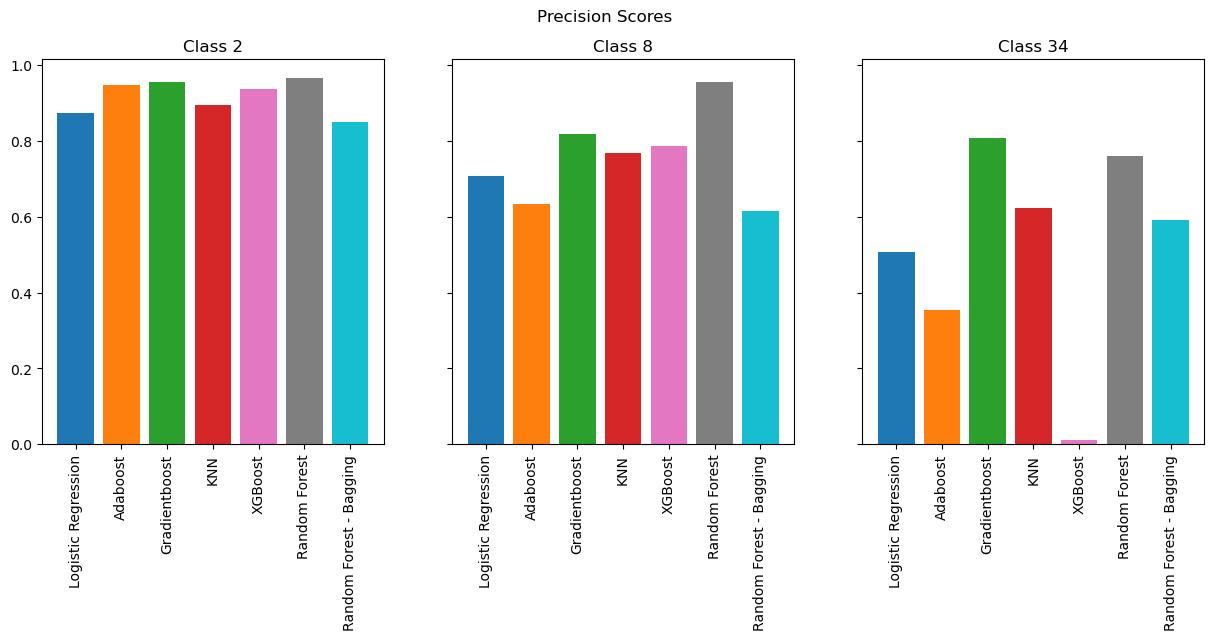

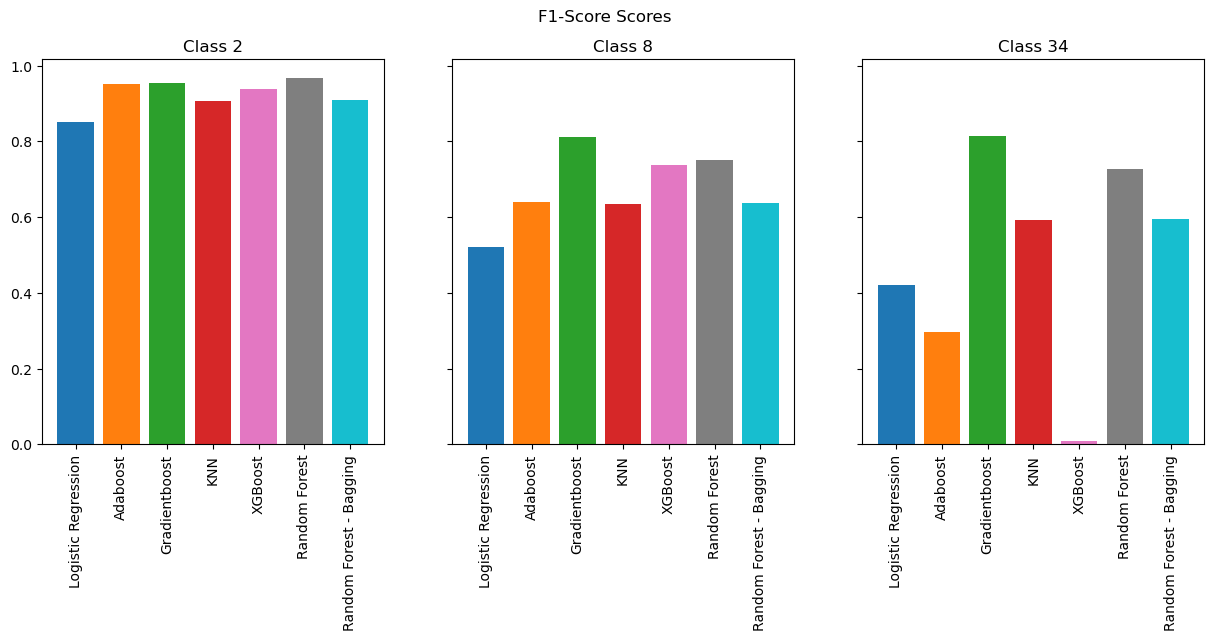

In [149]:
# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "XGBoost", "Random Forest", "Random Forest - Bagging"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "Adaboost": 'tab:orange',
    "Gradientboost": 'tab:green',
    "KNN": 'tab:red',
    "XGBoost": 'tab:pink',
    "Random Forest": 'tab:gray',
    "Random Forest - Bagging": 'tab:cyan'
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")

        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)

        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=90)

    # Save the figure
    plt.savefig(f'{metric}_scores.png', bbox_inches='tight')

    plt.show()




# Metric Table

In [150]:
# Concatenate them along rows
concatenated_data = pd.concat([metrics_2, metrics_8, metrics_34], ignore_index=False)

# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "XGBoost", "Random Forest", "Random Forest - Bagging"]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a DataFrame with the concatenated data
result_df = pd.DataFrame(concatenated_data.values,
                          pd.MultiIndex.from_product([["2 classes", "8 classes", "34 classes"], metrics]),
                          columns=model_names)

# Display the result
result_df


Logistic Regression  Adaboost Gradientboost       KNN  \
2 classes  Accuracy               0.9869  0.995313        0.9958  0.990962   
           Recall               0.832821  0.954278       0.95504  0.919494   
           Precision            0.871812  0.945825      0.954574  0.893136   
           F1-Score             0.851175  0.950009      0.954807  0.905862   
8 classes  Accuracy              0.83435  0.986513      0.992287  0.946338   
           Recall               0.492227  0.646662      0.802963  0.610501   
           Precision            0.707116  0.632825      0.818761  0.767016   
           F1-Score             0.521394  0.639412      0.810506  0.634444   
34 classes Accuracy             0.784225  0.756175      0.989675  0.930475   
           Recall               0.423299  0.329047      0.838182   0.58137   
           Precision             0.50763  0.353029      0.806386  0.622386   
           F1-Score             0.421282  0.296665      0.813165   0.59176   

                       XGBoost Random Forest Random Forest - Bagging  
2 classes  Accuracy   0.994325         0.997                0.989838  
           Recall     0.941724       0.97001                0.994539  
           Precision  0.936799      0.965713                0.850399  
           F1-Score   0.939247      0.967851                 0.90934  
8 classes  Accuracy   0.993738      0.994988                  0.9703  
           Recall      0.71978      0.727255                0.789175  
           Precision  0.786364      0.954936                0.614989  
           F1-Score   0.736504      0.751087                0.637716  
34 classes Accuracy   0.102038      0.993062                0.954825  
           Recall     0.031654      0.717702                0.714105  
           Precision   0.01178      0.758307                0.590585  
           F1-Score   0.009223      0.727089                0.594726

# Deep nural network

In [151]:
# Ajout des importations nécessaires pour la sauvegarde de modèle
import os
from datetime import datetime

# Fonction pour sauvegarder un modèle après entraînement
def save_model(model, model_name, classes):
    """
    Sauvegarde un modèle Keras après l'entraînement

    Parameters:
    -----------
    model : keras.Model
        Le modèle entraîné à sauvegarder
    model_name : str
        Nom du modèle (ex: "DNN")
    classes : int
        Nombre de classes utilisées pour l'entraînement (2, 8 ou 34)

    Returns:
    --------
    str
        Chemin où le modèle a été sauvegardé
    """
    # Utiliser le chemin spécifié pour Google Drive
    save_dir = "./saved_models"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Créer un nom de fichier avec timestamp pour éviter l'écrasement
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Sauvegarder en format H5 (nécessite l'extension .h5)
    h5_path = os.path.join(save_dir, f"{model_name}_{classes}classes_{timestamp}.h5")
    model.save(h5_path)
    print(f"Modèle sauvegardé avec succès au format H5: {h5_path}")

    # Sauvegarder en format .keras (nouveau format natif recommandé)
    keras_path = os.path.join(save_dir, f"{model_name}_{classes}classes_{timestamp}.keras")
    model.save(keras_path)
    print(f"Modèle sauvegardé avec succès au format Keras: {keras_path}")

    return h5_path, keras_path

In [152]:
# Ajout des importations nécessaires
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

# Configuration pour économiser la mémoire sur système à ressources limitées
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Limiter l'utilisation de la mémoire pour TensorFlow
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)

# Fonction pour créer un modèle DNN adapté aux contraintes système
def create_dnn_model(input_dim, output_dim, hidden_layers=[64, 32], dropout_rate=0.2):
    model = Sequential()

    # Première couche cachée
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Couches cachées additionnelles
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Couche de sortie
    if output_dim == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(Dense(output_dim, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'

    # Compilation avec optimiseur économe en mémoire
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss,
                  metrics=['accuracy'])

    return model

# Fonction pour entraîner et évaluer le modèle DNN
def train_evaluate_dnn(X_train, X_test, y_train, y_test, output_dim, class_weights=None, batch_size=32, epochs=30, classes=2, model_name="DNN"):
    input_dim = X_train.shape[1]

    # Adapter la taille du modèle selon la complexité du problème
    if classes <= 2:
        hidden_layers = [32, 16]  # Plus petit pour 2 classes
    elif classes <= 8:
        hidden_layers = [64, 32]  # Moyen pour 8 classes
    else:
        hidden_layers = [128, 64, 32]  # Plus grand pour 34 classes

    # Réduire la taille des batchs pour les systèmes à faible mémoire
    adjusted_batch_size = min(batch_size, 64)  # Pour s'assurer que ça tient en mémoire

    # Créer le modèle
    model = create_dnn_model(input_dim, output_dim, hidden_layers=hidden_layers)

    # Callbacks pour optimiser l'entraînement et économiser la mémoire
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    ]

    # Convertir à des arrays numpy pour tensorflow
    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train)
    X_test_np = np.array(X_test)
    y_test_np = np.array(y_test)

    # Entraînement avec validation
    history = model.fit(
        X_train_np, y_train_np,
        epochs=epochs,
        batch_size=adjusted_batch_size,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # Prédiction
    if output_dim == 2:
        y_pred_prob = model.predict(X_test_np, batch_size=adjusted_batch_size)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        y_pred = np.argmax(model.predict(X_test_np, batch_size=adjusted_batch_size), axis=1)

    # Évaluation
    accuracy = accuracy_score(y_test_np, y_pred)
    recall = recall_score(y_test_np, y_pred, average='macro')
    precision = precision_score(y_test_np, y_pred, average='macro')
    f1 = f1_score(y_test_np, y_pred, average='macro')

    # Insérer les métriques dans le dataframe
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])

    # Afficher le rapport de classification
    print(classification_report(y_test_np, y_pred, digits=3))

    # Afficher la matrice de confusion si applicable
    if classes == 2 or classes == 8:
        plt.figure(figsize=(4, 2), dpi=300)
        target_names = []
        if classes == 2:
            target_names = ["Attack", "Benign"]
        elif classes == 8:
            target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

        ConfusionMatrixDisplay(np.round(confusion_matrix(y_test_np, y_pred, normalize="true"), 2),
                               display_labels=target_names).plot()
        plt.xticks(rotation=90)

    return model, history

# Exemple d'utilisation pour 2 classes
# Mise à jour des fonctions d'exécution pour sauvegarder les modèles

def run_dnn_2classes():
    print("Exécution du DNN pour 2 classes...")
    scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df2")

    # Préparation des poids de classe pour gérer le déséquilibre
    weight_dict = get_weights(y_train)

    # Pour la classification binaire
    if 'benign' in y_train.unique():
        # Si les classes sont 0 et 1
        output_dim = 2
        # Créer des poids de classe compatibles avec keras
        class_weights = {i: weight_dict[label] for i, label in enumerate(weight_dict.keys())}
    else:
        # Si les classes sont déjà encodées
        output_dim = 2
        class_weights = weight_dict

    # Entraîner et évaluer le modèle DNN
    model_dnn, history = train_evaluate_dnn(
        scaled_X_train, scaled_X_test,
        encoded_y_train, encoded_y_test,
        output_dim=output_dim,
        class_weights=class_weights,
        batch_size=32,
        epochs=20,
        classes=2,
        model_name="DNN"
    )

    # Sauvegarder le modèle
    save_model(model_dnn, "DNN", 2)

    return model_dnn, history

def run_dnn_8classes():
    print("Exécution du DNN pour 8 classes...")
    scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df8")

    # Préparation des poids de classe
    weight_dict = get_weights(y_train)
    class_weights = {i: weight_dict[label] for i, label in enumerate(sorted(weight_dict.keys()))}

    # Entraîner et évaluer
    model_dnn, history = train_evaluate_dnn(
        scaled_X_train, scaled_X_test,
        encoded_y_train, encoded_y_test,
        output_dim=8,
        class_weights=class_weights,
        batch_size=32,
        epochs=25,
        classes=8,
        model_name="DNN"
    )

    # Sauvegarder le modèle
    save_model(model_dnn, "DNN", 8)

    return model_dnn, history

def run_dnn_34classes():
    print("Exécution du DNN pour 34 classes...")
    scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df34")

    # Préparation des poids de classe
    weight_dict = get_weights(y_train)
    class_weights = {i: weight_dict[label] for i, label in enumerate(sorted(weight_dict.keys()))}

    # Entraîner et évaluer avec des paramètres adaptés pour économiser de la mémoire
    model_dnn, history = train_evaluate_dnn(
        scaled_X_train, scaled_X_test,
        encoded_y_train, encoded_y_test,
        output_dim=34,
        class_weights=class_weights,
        batch_size=16,  # Batch size plus petit pour 34 classes
        epochs=15,      # Moins d'époques pour économiser du temps/mémoire
        classes=34,
        model_name="DNN"
    )

    # Sauvegarder le modèle
    save_model(model_dnn, "DNN", 34)

    return model_dnn, history

# Mettez à jour la liste des colonnes pour inclure DNN
columns = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN",
           "XGBoost", "Random Forest", "Random Forest - Bagging", "DNN"]

# Créer de nouveaux dataframes de métriques avec la colonne DNN
metrics_2 = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1-Score"], columns=columns)
metrics_8 = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1-Score"], columns=columns)
metrics_34 = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1-Score"], columns=columns)

# Pour exécuter les modèles DNN sur chaque ensemble de données


In [ ]:
run_dnn_2classes()

Exécution du DNN pour 2 classes...


In [ ]:
run_dnn_8classes()

In [ ]:
run_dnn_34classes()